# Initialization

In [1]:
COUNTRIES = [
'AU', 'AT', 'BE', 'CA', 'CZ', 'DK', 'FI', 'FR', 'DE', 'GB', 
'IT', 'JP', 'NL', 'PL', 'PT', 'SK', 'ES', 'SE', 'CH', 'US']

In [2]:
!python --version
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

Python 3.12.11


In [3]:
import json,sys,os

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt

import requests

import folium
from folium.plugins import MarkerCluster
from IPython.display import HTML,Image

from requests_ratelimiter import LimiterSession
session = LimiterSession(per_second=1)
session.headers.update({'User-Agent': 'safeweb','email':'safeweb@vut.cz'})

from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

from joblib import Memory
os.makedirs('__cache', exist_ok=True)
memory = Memory(location=f'__cache',verbose=0)

# Functions

In [4]:
@memory.cache
def REST_API_GET(url):

    result = pd.NA
    
    try:        
        result = session.get(url=url)
    except:
        print('REST API connection error.')
        raise SystemExit
    
    return result

In [5]:
@memory.cache
def WEB_VALID(url):

    result = False
    
    url = 'https://'+url
    
    try:
        response = requests.head(url, timeout=10, allow_redirects=True)
        if response.status_code == 200: result = True
    except:
        None

    return result

In [6]:
tlds = ['com', 'org', 'net', 'info', 'biz', 'name', 'pro',
        'app', 'blog', 'cloud', 'dev', 'ai', 'io', 'xyz', 
        'online', 'shop', 'store',  'edu', 'gov', 'mil', 
        'int', 'museum', 'aero', 'jobs']

In [7]:
def parse_website(url):

    result = pd.NA

    if pd.isna(url) or url == '' : return pd.NA

    # wrong openstreetmap records
    url = url.lower()
    url = url.replace('"','')
    url = url.split(';')[0]
    
    url = url.removeprefix('https://')
    url = url.removeprefix('http://')
    url = url.removeprefix('https')
    url = url.removeprefix('http')
    url = url.removeprefix('//')    
    url = url.removeprefix('wwww.')
    url = url.split('/')[0]
    website = '.'.join(url.split('.')[-2:])

    # tld in 2nd-level
    test = website.split('.')
                  
    # pre-check for major websites
    if len(website) > 1 and len(test) == 2 and not test[-2] in tlds and not test[-1].isnumeric() and len(test[-2]) >= 10:         

        result = website
    
    return result

In [8]:
def country_to_area(country):
    
    area_id = pd.NA

    url = f'https://nominatim.openstreetmap.org/search?country={country}&format=json'
    
    response = REST_API_GET(url)
    
    if pd.notna(response) and response.status_code == 200:
        
        try:
            response_data = json.loads(response.text)
            
            # find first relation record
            for record in response_data:    
                if record['osm_type'] == 'relation':
                    area_id = record['osm_id'] + 3600000000; break
        except:
            print('REST API data error.')
            raise SystemExit
            
    else:      
        print('REST API request error.')
        raise SystemExit

    return area_id

In [9]:
def get_country_urls(area):

    urls = []

    query = f'''[out:json][timeout:1200];
    area({area}) -> .country;
    (
      nw['website'](area.country);
    );
    out center;'''
    
    #url = f'https://overpass-api.de/api/interpreter?data={query}'
    url = f'https://overpass.kumi.systems/api/interpreter?data={query}'
    
    response = REST_API_GET(url)
    
    if pd.notna(response) and response.status_code == 200:
        try:
            response_data = response.json()['elements']

            for item in response_data:
                if item['type'] == 'node': 
                    urls.append(['node',item['tags']['website'],item['lat'],item['lon'],item['tags']])
                else:
                    urls.append(['way',item['tags']['website'],item['center']['lat'],item['center']['lon'],item['tags']])
                    
        except:
            print('REST API data error.')
            raise SystemExit
    else:
        print('REST API request error.')
        raise SystemExit
   
    if len(urls) == 0: urls = pd.NA

    return urls

In [10]:
facility_type = pd.read_csv('curration-defs/facility.txt', header=None,names=['text'])
facility_type.text = facility_type.text.str.lower()
facility_type = facility_type.sort_values(by='text')
facility_type = facility_type.drop_duplicates()

content = "; ".join(facility_type.text.astype(str).str.replace('_', r'\_'))
with open('curration-defs/facility_table.txt', 'w') as f:
    f.write(content)

facility_type.text.to_csv(f'curration-defs/facility.txt', index=False, header=False)

facility_type

,text
0,aerodrome
1,alpine_hut
2,alternative
3,alzheimer
4,alzheimer's
...,...
264,water_park
265,weighbridge
266,winter_sports
267,yoga


In [11]:
commerce_type = pd.read_csv('curration-defs/commerce.txt', header=None,names=['text'])
commerce_type.text = commerce_type.text.str.lower()
commerce_type = commerce_type.sort_values(by='text')
commerce_type = commerce_type.drop_duplicates()

commerce_type.text.to_csv(f'curration-defs/commerce.txt', index=False, header=False)

content = "; ".join(commerce_type.text.astype(str).str.replace('_', r'\_'))
with open('curration-defs/commerce_table.txt', 'w') as f:
    f.write(content)

commerce_type

,text
0,accountant
1,advertising_agency
2,agrarian
3,airsoft
4,alcohol
...,...
200,wholesale
201,wine
202,winery
203,works


In [12]:
forbidden_type = pd.read_csv('curration-defs/forbidden.txt', header=None,names=['text'])
forbidden_type.text = forbidden_type.text.str.lower()
forbidden_type = forbidden_type.sort_values(by='text')
forbidden_type = forbidden_type.drop_duplicates()

content = "; ".join(forbidden_type.text.astype(str).str.replace('_', r'\_'))
with open('curration-defs/forbidden_table.txt', 'w') as f:
    f.write(content)

forbidden_type.text.to_csv(f'curration-defs/forbidden.txt', index=False, header=False)

forbidden_type

,text
0,adult_gaming_centre
1,brothel
2,casino
3,erotic
4,fake
5,gambling
6,hookah_lounge
7,love_hotel
8,nightclub
9,prostitution


In [13]:
facility_dict = {key:'Facility' for key in facility_type.text}
commerce_dict = {key:'Commerce' for key in commerce_type.text}
forbidden_dict = {key:'Forbidden' for key in forbidden_type.text}
text_cat = {**facility_dict,**commerce_dict,**forbidden_dict}

text_cat

{'aerodrome': 'Facility',
 'alpine_hut': 'Facility',
 'alternative': 'Facility',
 'alzheimer': 'Facility',
 "alzheimer's": 'Facility',
 'amusement_arcade': 'Facility',
 'animal_boarding': 'Facility',
 'animal_breeding': 'Facility',
 'animal_shelter': 'Facility',
 'animal_training': 'Facility',
 'apartment': 'Facility',
 'archive': 'Facility',
 'art_school': 'Facility',
 'arts_centre': 'Facility',
 'atelier': 'Facility',
 'atm': 'Facility',
 'attraction': 'Facility',
 'audiologist': 'Facility',
 'baby_hatch': 'Facility',
 'bank': 'Facility',
 'bar': 'Facility',
 'bbq': 'Facility',
 'beauty': 'Facility',
 'bench': 'Facility',
 'bicycle_library': 'Facility',
 'bicycle_parking': 'Facility',
 'bicycle_rental': 'Facility',
 'bicycle_repair_station': 'Facility',
 'bicycle_wash': 'Facility',
 'biergarten': 'Facility',
 'blood_bank': 'Facility',
 'bmx': 'Facility',
 'bowling_alley': 'Facility',
 'bowls': 'Facility',
 'bureau_de_change': 'Facility',
 'bus_station': 'Facility',
 'cafe': 'Facility

In [14]:
def get_tag_text(tags,tag):
    
    result = pd.NA
    
    tag_text = tags.get(tag,pd.NA)    
    if tag_text is pd.NA: tag_text = tags.get('disused:'+tag,pd.NA)
    if tag_text is pd.NA: tag_text = tags.get('was:'+tag,pd.NA)  
    if tag_text is pd.NA: tag_text = tags.get('speciality:'+tag,pd.NA)

    if tag_text is not pd.NA: tag_text.lower()
        
    result = tag_text
    
    return result

In [15]:
def get_place_type(tags):

    tag_types = [
        'amenity', 'shop', 'healthcare', 'craft', 'tourism', 
        'leisure', 'landuse', 'man_made', 'place', 'industrial',
        'sport', 'club', 'denomination', 'office', 'cuisine',
        'building', 'waterway', 'aeroway'
    ]
    
    for tag in tag_types:
        tag_text = get_tag_text(tags=tags, tag=tag)
        if tag_text is not pd.NA:
            result = text_cat.get(tag_text.lower(), pd.NA)
            if result is not pd.NA:
                return result
    
    yes_mapping = {
        'office': 'Commerce',
        'shop': 'Commerce',
        'club': 'Facility',
        'healthcare': 'Facility'
    }
    
    for tag, value in yes_mapping.items():
        tag_text = get_tag_text(tags=tags, tag=tag)
        if tag_text is not pd.NA and tag_text == 'yes':
            return value
    
    # check for key presence
    commerce_keys = ['workshop', 'parcelshop', 'operator', 'payment:american_express',
                    'payment:cash', 'payment:checks', 'payment:discover_card',
                    'payment:mastercard', 'payment:visa', 'payment:credit_cards',
                    'payment:debit_cards', 'fuel']
    if any(key in tags for key in commerce_keys):
        return 'Commerce'
    
    facility_keys = ['attraction', 'boundary', 'camera', 'cemetery', 'crop',
                    'emergency', 'highway', 'historic', 'military', 'natural',
                    'parking', 'population', 'public_transport', 'railway',
                    'road', 'route', 'telecom', 'polling_station', 'company',
                    'industrial', 'power', 'construction', 'telecom', 'religion','emergency']
    if any(key in tags for key in facility_keys):
        return 'Facility'

    # here we check for text matching
    forbidden_keys = ['adult_gaming_centre', 'brothel', 'casino', 'erotic',
                     'gambling', 'hookah', 'love', 'nightclub', 'prostitution',
                     'sexshop', 'stripclub', 'swingerclub']
    if any(key in tags for key in forbidden_keys):
        return 'Forbidden'
    
    return 'Unknown'

In [16]:
def frame_info(frame,mem=False,dtype=False,sample=False,n=5,width=50,columns=50):

    size = len(frame)

    if mem: 
        print(round(frame.memory_usage(deep=True)/(1024**3),1).to_string())
        print('Total ',round(frame.memory_usage(deep=True).sum()/(1024**3),1))

    if dtype:
        print()
        print(frame.dtypes.to_string())     

    if sample:
        print(size)
        frame = frame.sample(min(n,size))

    with pd.option_context('display.min_rows', n, 'display.max_rows', n,
                           'display.max_columns', columns,'display.max_colwidth', width):
        display(frame)

    return

# Main

In [17]:
data = pd.DataFrame(COUNTRIES,columns = ['country'])
data.country = data.country.astype('category')

data['area'] = data.country.progress_apply(country_to_area)
data.area = data.area.astype('category')

data['urls'] = data.progress_apply(lambda r: get_country_urls(r.area),axis=1)
data.pop('area')

data = data.explode('urls',ignore_index=True).rename(columns = {'urls':'url'})
data[['osm','url','lat','lon','tags']] = pd.DataFrame(data.url.tolist(), index=data.index)

data.osm = data.osm.astype('category')
data.url = data.url.str.lower()
data.url = data.url.astype(pd.StringDtype('pyarrow'))
data.lat = data.lat.astype(pd.StringDtype('pyarrow'))
data.lon = data.lon.astype(pd.StringDtype('pyarrow'))

data = data.sample(frac=1)

frame_info(data,dtype=True)

100%|███████████████████████████████████████████████████████████████| 20/20 [00:15<00:00,  1.33it/s]

country           category
url        string[pyarrow]
osm               category
lat        string[pyarrow]
lon        string[pyarrow]
tags                object


,country,url,osm,lat,lon,tags
1039285,DE,https://filiale.kaufland.de/service/filiale/we...,way,49.3341193,11.1150514,"{'amenity': 'fuel', 'brand': 'Kaufland', 'bran..."
1858344,PL,http://www.osm.konin.pl,way,52.2293204,18.23598,"{'landuse': 'industrial', 'man_made': 'works',..."
...,...,...,...,...,...,...
1304765,GB,https://jcmcableinstallation.com/,node,54.7488234,-1.291377,"{'addr:city': 'Hartlepool', 'addr:country': 'G..."
76878,AT,http://www.augumaug-zahnumzahn.at/auge.html,node,47.1055119,15.7058559,"{'OGD-Stmk:ARZTNR': '6566.0', 'OGD-Stmk:OBJECT..."


In [18]:
data['website'] = data.url.progress_apply(parse_website)
data.pop('url')
todrop = data.loc[data.website.isna()]
print(len(todrop))
data = data.drop(todrop.index)
data.website = data.website.astype(pd.StringDtype('pyarrow'))

100%|█████████████████████████████████████████████████| 2916062/2916062 [00:03<00:00, 940832.92it/s]
1372871


In [19]:
website_counts = data.website.value_counts()
todrop = website_counts[website_counts > 1].index
todrop = data.loc[data.website.isin(todrop)]
print(len(todrop))
data = data.drop(todrop.index)

frame_info(data,dtype=True)

643901

country           category
osm               category
lat        string[pyarrow]
lon        string[pyarrow]
tags                object
website    string[pyarrow]


,country,osm,lat,lon,tags,website
1166450,DE,way,49.9175852,8.6413027,"{'addr:housenumber': '18', 'addr:postcode': '6...",cz-darmstadt.de
1764436,PL,node,51.5056544,16.0674888,"{'addr:postcode': '59-100', 'name': 'Kancelari...",adwokatmichalski.com
...,...,...,...,...,...,...
1304765,GB,node,54.7488234,-1.291377,"{'addr:city': 'Hartlepool', 'addr:country': 'G...",jcmcableinstallation.com
76878,AT,node,47.1055119,15.7058559,"{'OGD-Stmk:ARZTNR': '6566.0', 'OGD-Stmk:OBJECT...",augumaug-zahnumzahn.at


In [20]:
data['place_type'] = data.tags.progress_apply(get_place_type)
data.place_type = data.place_type.astype('category')

frame_info(data,mem=True,sample=True,n=10)

100%|███████████████████████████████████████████████████| 899290/899290 [00:01<00:00, 580962.96it/s]
Index         0.0
country       0.0
osm           0.0
lat           0.0
lon           0.0
tags          0.3
website       0.0
place_type    0.0
Total  0.4
899290


,country,osm,lat,lon,tags,website,place_type
520665,FR,node,47.7805906,-3.4183482,"{'addr:city': 'Quéven', 'addr:postcode': '5653...",pharmagest.com,Commerce
2601450,US,way,42.6123058,-71.5798177,"{'addr:city': 'Groton', 'addr:housenumber': '2...",sevenhills.org,Facility
722348,DE,node,47.5487911,9.683018,"{'amenity': 'boat_rental', 'contact:email': 'i...",bootsverleih-lindau.de,Commerce
1730800,NL,way,52.3512327,4.9207172,"{'amenity': 'pub', 'name': 'Vergulden Eenhoorn...",verguldeneenhoorn.nl,Facility
2718079,US,way,44.0585666,-121.313392,"{'addr:city': 'Bend', 'addr:housenumber': '118...",jeffreymurrayphotography.com,Commerce
775787,DE,node,47.4150589,10.235735,"{'addr:city': 'Oberstdorf', 'addr:country': 'D...",andreas-muetsch.de,Facility
1689621,NL,node,52.0350926,4.3073721,"{'addr:city': 'Rijswijk', 'addr:housenumber': ...",olive-traiteur.nl,Facility
2203393,US,node,35.0803994,-106.6079087,"{'addr:city': 'Albuquerque', 'addr:housenumber...",chocolatedudeabq.com,Commerce
84385,AT,node,48.3831442,15.5583538,"{'addr:city': 'Mauternbach', 'addr:country': '...",weingut-graf.at,Facility
657655,FR,way,48.0599126,5.5652859,"{'addr:housenumber': '5', 'addr:postcode': '52...",campingsaintnicolas.com,Facility


In [21]:
data['website_valid'] = data.website.progress_apply(WEB_VALID)

todrop = data.loc[data.website_valid != True]
print(len(todrop))
data = data.drop(todrop.index)
data.pop('website_valid')

frame_info(data,mem=True,sample=True,n=10)

100%|████████████████████████████████████████████████████| 899290/899290 [01:08<00:00, 13061.78it/s]
321145
Index         0.0
country       0.0
osm           0.0
lat           0.0
lon           0.0
tags          0.2
website       0.0
place_type    0.0
Total  0.2
578145


,country,osm,lat,lon,tags,website,place_type
1467593,IT,node,42.1449008,12.4901916,"{'addr:city': 'Morlupo', 'addr:housenumber': '...",podologialaguardia.it,Facility
1246465,GB,node,51.559677,-0.1100727,"{'addr:city': 'London', 'addr:housenumber': '1...",thevillagepractice.org,Facility
655902,FR,way,45.2113995,6.354036,"{'landuse': 'winter_sports', 'name': 'Albiez-M...",station-albiez.com,Facility
1001806,DE,node,54.1275877,8.8636655,"{'addr:city': 'Büsum', 'addr:housenumber': '19...",museum-am-meer.de,Facility
619274,FR,way,43.9401306,4.8207783,"{'addr:city': 'Avignon', 'addr:housenumber': '...",danse-avignon.fr,Facility
2402427,US,node,32.3599627,-111.0858082,"{'addr:city': 'Tucson', 'addr:housenumber': '5...",itouchdayspa.net,Facility
2626014,US,way,40.3623485,-111.7794621,"{'addr:city': 'American Fork', 'addr:housenumb...",youscience.com,Commerce
680644,DE,node,51.1746328,6.8773785,"{'addr:city': 'Düsseldorf', 'addr:country': 'D...",foerderschule-sehen-duesseldorf.de,Facility
739273,DE,node,50.9290672,6.9117118,"{'addr:city': 'Köln', 'addr:country': 'DE', 'a...",optik-hess.eu,Commerce
1822204,PL,node,50.351903,19.3445976,"{'addr:city': 'Dąbrowa Górnicza', 'addr:housen...",rowerowanorka.pl,Commerce


# Tests

In [22]:
data.loc[data.website.isna()]

,country,osm,lat,lon,tags,website,place_type


In [23]:
data.loc[data.lat.isna()]

,country,osm,lat,lon,tags,website,place_type


In [24]:
data.loc[data.place_type.isna()]

,country,osm,lat,lon,tags,website,place_type


# Reports

In [25]:
data.loc[data.place_type == 'Facility'].sample(10)

,country,osm,lat,lon,tags,website,place_type
2508005,US,node,39.3590328,-74.4274852,"{'addr:housenumber': '155 South', 'addr:postco...",haydaycoffee.com,Facility
1093891,DE,way,49.3185044,8.5500467,"{'addr:city': 'Hockenheim', 'addr:country': 'D...",stadthalle-hockenheim.de,Facility
2254724,US,node,40.5581231,-75.572407,"{'addr:city': 'Allentown', 'addr:housenumber':...",parrishchiro.com,Facility
2212117,US,node,43.2546175,-83.7395473,"{'addr:city': 'Birch Run', 'addr:housenumber':...",pineridgerv.com,Facility
2795366,US,way,37.2833026,-107.8751303,"{'alt_name': 'Saint Columba Pre-School', 'amen...",stcolumbaschooldurango.org,Facility
2635393,US,way,38.8390888,-104.8228467,"{'addr:housenumber': '321', 'addr:postcode': '...",fourbybrotherluck.com,Facility
252390,CA,node,51.0707472,-114.1043808,"{'addr:city': 'Calgary', 'addr:housenumber': '...",theartistlounge.ca,Facility
2777692,US,way,27.6507984,-80.3572736,"{'addr:housenumber': '3103', 'addr:street': 'C...",tidesofvero.com,Facility
2438914,US,node,40.7363193,-74.1692229,"{'addr:city': 'Newark', 'addr:housenumber': '4...",queenpizzaii.com,Facility
306252,CZ,node,49.229281,16.5856804,"{'addr:city': 'Brno', 'addr:housenumber': '265...",restauraceportoriko.cz,Facility


In [26]:
data.loc[data.place_type == 'Commerce'].sample(10)

,country,osm,lat,lon,tags,website,place_type
2098997,CH,node,47.1399986,7.2467058,"{'addr:city': 'Biel/Bienne', 'addr:city:de': '...",second-chance.ch,Commerce
2132183,CH,way,47.1210626,7.5330135,"{'landuse': 'farmyard', 'name': 'Berchtoldshof...",berchtoldshof.ch,Commerce
2362948,US,node,30.3476258,-97.7148987,"{'addr:city': 'Austin', 'addr:housenumber': '9...",itstimetexas.org,Commerce
2865285,US,way,37.3997479,-79.1598764,"{'addr:city': 'Lynchburg', 'addr:housenumber':...",jamersonlewis.com,Commerce
2066613,SE,way,56.8253119,14.047295,"{'addr:city': 'Tutaryd', 'building': 'industri...",lindenvillan.com,Commerce
1476015,IT,node,41.9005246,12.4757194,"{'addr:housenumber': '73', 'addr:street': 'Via...",braccicamiceriasartoria.com,Commerce
800325,DE,node,51.6717015,8.5864998,"{'addr:city': 'Salzkotten', 'addr:country': 'D...",burs-schroeder.de,Commerce
2464807,US,node,43.394245,-70.5300525,"{'addr:city': 'Kennebunk', 'addr:housenumber':...",moonandback.com,Commerce
546004,FR,node,43.2692772,5.3924877,"{'addr:city': 'Marseille', 'addr:housenumber':...",bengous-shop.com,Commerce
1646161,NL,node,52.2285928,5.3688933,"{'addr:city': 'Bunschoten-Spakenburg', 'addr:h...",bistrosaus.nl,Commerce


In [27]:
data.loc[data.place_type == 'Unknown'].sample(10)

,country,osm,lat,lon,tags,website,place_type
2326911,US,node,42.1659672,-71.0439616,"{'addr:housenumber': '9', 'addr:street': 'Warr...",eyecareetc.com,Unknown
949884,DE,node,48.3156575,11.9115141,"{'addr:city': 'Erding', 'addr:country': 'DE', ...",kleingaertnerverein-erding.de,Unknown
2427859,US,node,45.4913576,-122.8486103,"{'addr:city': 'Aloha', 'addr:housenumber': '16...",beavertontowing.com,Unknown
892779,DE,node,53.674867,10.1399611,"{'craft': 'paver', 'name': 'KB Fachboden GmbH'...",kb-fachboden.de,Unknown
137711,AT,way,47.9515254,16.8345067,"{'addr:city': 'Neusiedl am See', 'addr:country...",dachdeckerei-haider.at,Unknown
1164866,DE,way,53.073087,8.761826,"{'addr:housenumber': '13', 'addr:street': 'Ger...",klgv-wardamm-woltmershausen.de,Unknown
993602,DE,node,50.5378965,8.5310878,"{'addr:city': 'Wetzlar', 'addr:housenumber': '...",haaratelier.de,Unknown
846964,DE,node,49.0036527,8.3817259,"{'addr:housenumber': '10', 'addr:postcode': '7...",steuerberater-ka.de,Unknown
1024859,DE,node,48.4489312,10.2217758,"{'email': 'info@logopaedie-leipheim.de', 'fax'...",logopaedie-leipheim.de,Unknown
1135183,DE,way,53.622853,10.2707867,"{'addr:housenumber': '2', 'addr:street': 'Mühl...",muehle-meilsdorf.de,Unknown


In [28]:
data.loc[data.place_type == 'Forbidden'].sample(10)

,country,osm,lat,lon,tags,website,place_type
654707,FR,way,46.0514319,3.9319237,"{'addr:city': 'Renaison', 'addr:housenumber': ...",cabaret-elegance.fr,Forbidden
474261,FR,node,46.1555071,-1.1601256,"{'addr:city': 'La Rochelle', 'addr:postcode': ...",oxford-club.fr,Forbidden
932356,DE,node,53.6168659,9.9058995,"{'amenity': 'hookah_lounge', 'name': 'Toxid Lo...",toxid-lounge.de,Forbidden
763878,DE,node,52.5344022,13.3597082,"{'addr:city': 'Berlin', 'addr:country': 'DE', ...",slaughterhouse-berlin.de,Forbidden
1070155,DE,way,52.2001073,8.539592,"{'addr:city': 'Bünde', 'addr:country': 'DE', '...",eros-buende.de,Forbidden
2694243,US,way,46.7236046,-92.1044108,"{'addr:city': 'Superior', 'addr:housenumber': ...",mainclubsuperior.com,Forbidden
1146597,DE,way,51.208076,7.2135611,"{'addr:city': 'Remscheid', 'addr:housenumber':...",club-deja-vu.de,Forbidden
838555,DE,node,54.7677052,9.43801,"{'addr:city': 'Flensburg', 'addr:country': 'DE...",roxy-concerts.de,Forbidden
1590092,JP,node,35.7840719,139.8996038,"{'addr:block_number': '1', 'addr:city': '松戸市',...",image-club.jp,Forbidden
174091,BE,node,50.8841042,4.7133788,"{'addr:housenumber': '15', 'addr:postcode': '3...",stelplaats.be,Forbidden


# Samples

In [29]:
data.drop_duplicates(subset='country')

,country,osm,lat,lon,tags,website,place_type
1166450,DE,way,49.9175852,8.6413027,"{'addr:housenumber': '18', 'addr:postcode': '6...",cz-darmstadt.de,Facility
1764436,PL,node,51.5056544,16.0674888,"{'addr:postcode': '59-100', 'name': 'Kancelari...",adwokatmichalski.com,Commerce
389308,DK,way,54.9438846,9.3702823,"{'alt_name': 'SBS Aabenraa Biogas', 'barrier':...",sbskliplev.dk,Commerce
1454784,IT,node,41.9297356,12.5229875,"{'addr:city': 'Roma', 'addr:housenumber': '5',...",ristorantemaestrale.com,Facility
667282,FR,way,50.9863671,1.9694904,"{'caravans': 'yes', 'name': 'Camping La Plage'...",campingplage62.fr,Facility
1255661,GB,node,50.8345587,-0.1692241,"{'addr:housenumber': '84', 'addr:postcode': 'B...",theboilerroomsauna.com,Unknown
2496869,US,node,44.9400742,-93.0997928,"{'addr:housenumber': '230', 'addr:postcode': '...",littlebrazilmn.com,Facility
267506,CA,way,43.6133098,-79.562282,"{'addr:city': 'Etobicoke', 'addr:housenumber':...",acurasherway.com,Commerce
1736021,NL,way,53.1388429,6.2109265,"{'email': 'info@bosparktrimunt.nl', 'mobile': ...",bosparktrimunt.nl,Facility
133392,AT,way,46.8259676,15.4505929,"{'addr:city': 'Sankt Nikolai im Sausal', 'addr...",zumthomann.at,Facility


# Visual

AU
100%|███████████████████████████████████████████████████████| 2306/2306 [00:00<00:00, 216847.86it/s]
AT
100%|█████████████████████████████████████████████████████| 19579/19579 [00:00<00:00, 219159.81it/s]
BE
100%|██████████████████████████████████████████████████████| 14185/14185 [00:00<00:00, 95432.73it/s]
CA
100%|█████████████████████████████████████████████████████| 21429/21429 [00:00<00:00, 218323.75it/s]
CZ
100%|███████████████████████████████████████████████████████| 7877/7877 [00:00<00:00, 182104.73it/s]
DK
100%|███████████████████████████████████████████████████████| 7104/7104 [00:00<00:00, 222026.02it/s]
FI
100%|███████████████████████████████████████████████████████| 6811/6811 [00:00<00:00, 215261.88it/s]
FR
100%|█████████████████████████████████████████████████████| 48598/48598 [00:00<00:00, 159549.82it/s]
DE
100%|███████████████████████████████████████████████████| 171048/171048 [00:01<00:00, 133799.68it/s]
GB
100%|█████████████████████████████████████████████████████| 1

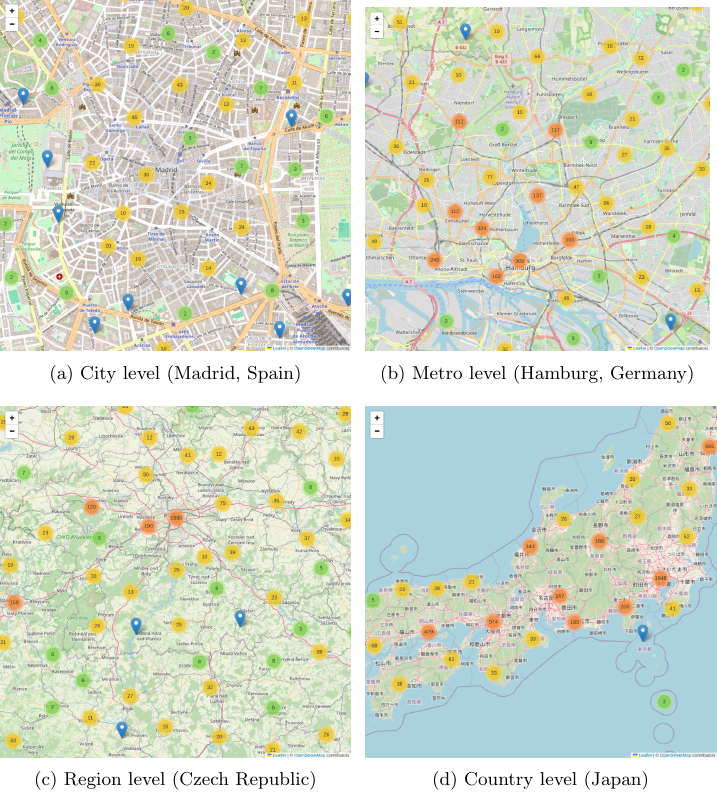

In [30]:
for item in COUNTRIES:
    print(item)

    item_data = data.loc[data.country == item]

    map_fl = folium.Map(zoom_start=13, width=800, height=800)
    marker_cluster = MarkerCluster().add_to(map_fl)
    
    for itemA in tqdm(item_data.itertuples(), total=len(item_data), file=sys.stdout, ncols=100):
        folium.Marker(location=[itemA.lat,itemA.lon]).add_to(marker_cluster)

    map_fl.save(f'result-visual/safeweb-{item}.html')  
    
# sample
#display(HTML(open(f'result-visual/safeweb-{item}.html').read()))
print()
Image('result-visual/example-maps.png')

# Demo

In [31]:
# demo area
lat,lon = [48.158,11.552]
size = 50 #km

In [32]:
data['crd'] = gpd.points_from_xy(data.lon,data.lat)
data = gpd.GeoDataFrame(data)
data.crd = data.crd.set_crs('EPSG:4326')

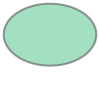

In [33]:
area = sh.Point(lon,lat)
area = gpd.GeoSeries(area).set_crs('EPSG:4326')
area = area.to_crs(area.estimate_utm_crs())
area = area.buffer(size*1000)
area = area.to_crs('EPSG:4326')
area.item()

In [34]:
data_area = data.loc[data.crd.within(area.item())]

data_area

,country,osm,lat,lon,tags,website,place_type,crd
1121102,DE,way,48.0813637,12.0892391,"{'contact:city': 'Forsting', 'contact:housenum...",brauerei-forsting.de,Commerce,POINT (12.08924 48.08136)
875838,DE,node,48.1151174,11.6954647,"{'addr:city': 'München', 'addr:housenumber': '...",holiway-reisen.de,Commerce,POINT (11.69546 48.11512)
922949,DE,node,48.4000253,11.743817,"{'addr:city': 'Freising', 'addr:country': 'DE'...",3klang-musik.de,Facility,POINT (11.74382 48.40003)
743800,DE,node,48.058921,11.7720362,"{'addr:city': 'Grasbrunn', 'addr:country': 'DE...",erc-baumann.de,Commerce,POINT (11.77204 48.05892)
1135058,DE,way,48.4267366,11.7550711,"{'addr:city': 'Freising', 'addr:country': 'DE'...",kleintierpraxis-drspiess.de,Commerce,POINT (11.75507 48.42674)
...,...,...,...,...,...,...,...,...
1004761,DE,node,48.1656461,11.5727646,"{'check_date': '2024-11-05', 'email': 'info@ma...",macverleih.de,Commerce,POINT (11.57276 48.16565)
699715,DE,node,48.1791058,11.2539501,"{'addr:city': 'Fürstenfeldbruck', 'addr:housen...",destille-ffb.de,Commerce,POINT (11.25395 48.17911)
875920,DE,node,47.8344678,11.127989,"{'addr:city': 'Weilheim in Oberbayern', 'addr:...",oberland-pumpenservice.de,Commerce,POINT (11.12799 47.83447)
1101611,DE,way,48.0962698,11.3631519,"{'addr:city': 'Krailling', 'addr:country': 'DE...",markus-dehoff.de,Commerce,POINT (11.36315 48.09627)


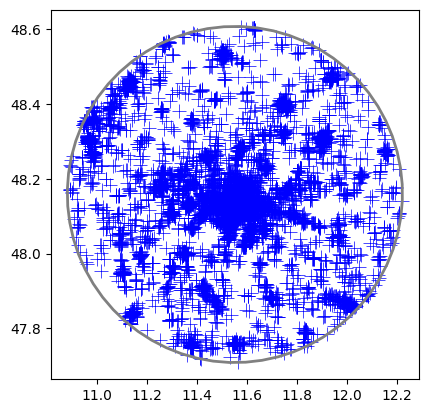

In [35]:
ax = area.boundary.plot(color='grey',lw = 2)
data_area.crd.plot(ax = ax,marker = '+', color = 'blue',markersize = 100,lw = 0.5)
plt.savefig(f'result-visual/demo-map-area.png',bbox_inches='tight',pad_inches=0.01)

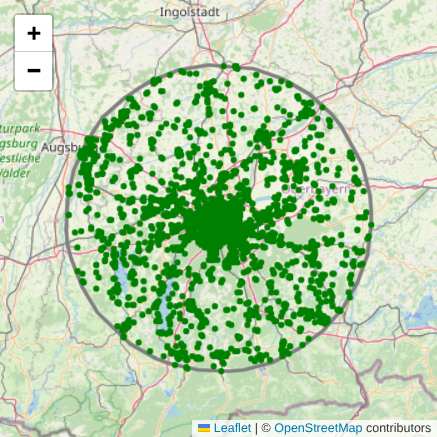

In [36]:
map_fl = folium.Map(location=[lat,lon],zoom_start=8,width=350,height=350)

crds = [(item[1], item[0]) for item in area.item().exterior.coords]
poly_fl = folium.Polygon(locations=crds,color='gray')
poly_fl.add_to(map_fl)

for item in data_area.loc[data_area.place_type == 'Facility'].itertuples():
    folium.CircleMarker(color='green',radius=1,
        location=[item.lat,item.lon],
        size=1).add_to(map_fl)    

map_fl.save('result-visual/demo-map-facility.html')
#display(HTML(open('result-visual/demo-map-facility.html').read()))
Image('result-visual/demo-map-facility.png')

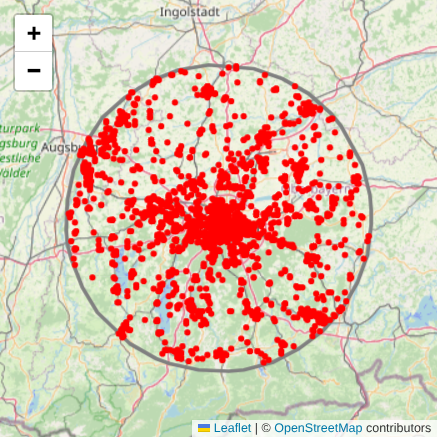

In [37]:
map_fl = folium.Map(location=[lat,lon],zoom_start=8,width=350,height=350)

crds = [(item[1], item[0]) for item in area.item().exterior.coords]
poly_fl = folium.Polygon(locations=crds,color='gray')
poly_fl.add_to(map_fl)   

for item in data_area.loc[data_area.place_type == 'Commerce'].itertuples():
    folium.CircleMarker(color='red',radius=1,
        location=[item.lat,item.lon],
        size=1).add_to(map_fl)

map_fl.save('result-visual/demo-map-commerce.html')
#display(HTML(open('result-visual/demo-map-commerce.html').read()))
Image('result-visual/demo-map-commerce.png')

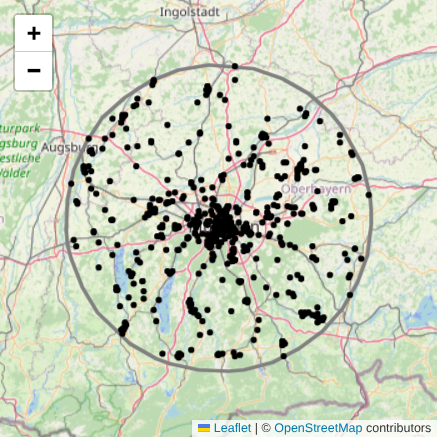

In [38]:
map_fl = folium.Map(location=[lat,lon],zoom_start=8,width=350,height=350)

crds = [(item[1], item[0]) for item in area.item().exterior.coords]
poly_fl = folium.Polygon(locations=crds,color='gray')
poly_fl.add_to(map_fl)   

for item in data_area.loc[data_area.place_type == 'Unknown'].itertuples():
    folium.CircleMarker(color='black',radius=1,
        location=[item.lat,item.lon],
        size=1).add_to(map_fl)

map_fl.save('result-visual/demo-map-unknown.html')
#display(HTML(open('result-visual/demo-map-unknown.html').read()))
Image('result-visual/demo-map-unknown.png')

# Validation

In [82]:
VAL_COUNTRY = 'CZ'

In [83]:
gt_facility = pd.read_csv(f'ground-truth/ground-truth-{VAL_COUNTRY}-facility.txt',header=None,names=['website'])
gt_facility['gt_place_type'] = 'Facility'
gt_facility

,website,gt_place_type
0,adrenalin-park.cz,Facility
1,akcent-hotel.cz,Facility
2,alzheimerhome.cz,Facility
3,amarorecords.cz,Facility
4,apartmanymaxov.cz,Facility
...,...,...
453,zskorycany.cz,Facility
454,zsmsprosetin.cz,Facility
455,zsnestemicka.cz,Facility
456,zszeleznice.cz,Facility


In [84]:
gt_commerce = pd.read_csv(f'ground-truth/ground-truth-{VAL_COUNTRY}-commerce.txt',header=None,names=['website'])
gt_commerce['gt_place_type'] = 'Commerce'
gt_commerce

,website,gt_place_type
0,a-z-sekacky.cz,Commerce
1,administratori.cz,Commerce
2,agravelkytynec.cz,Commerce
3,annamaresova.com,Commerce
4,as-superwash.cz,Commerce
...,...,...
139,zelezarstvi-soukup.cz,Commerce
140,zelezarstvikeller.cz,Commerce
141,zlatafontana.cz,Commerce
142,zlatnictvihanys.cz,Commerce


In [85]:
gt_facility = gt_facility.sort_values(by='website')
gt_facility.website.to_csv(f'ground-truth/ground-truth-{VAL_COUNTRY}-facility.txt',header=None,index=None)

gt_commerce = gt_commerce.sort_values(by='website')
gt_commerce.website.to_csv(f'ground-truth/ground-truth-{VAL_COUNTRY}-commerce.txt',header=None,index=None)

In [86]:
gt = pd.concat([gt_facility,gt_commerce],axis=0)
display(gt.loc[gt.website.duplicated()])

val = pd.merge(gt, data, how='left', on='website')

val.loc[pd.isna(val.place_type)]
val = val.dropna()
val

,website,gt_place_type


,website,gt_place_type,country,lat,lon,place_type
0,adrenalin-park.cz,Facility,CZ,50.2735102,17.227092,Commerce
1,akcent-hotel.cz,Facility,CZ,50.0686344,14.402821,Facility
3,amarorecords.cz,Facility,CZ,49.2004847,16.6126485,Facility
4,apartmanymaxov.cz,Facility,CZ,50.7623312,15.2190424,Facility
5,apartmanyustarenky.cz,Facility,CZ,48.8564965,17.028943,Facility
...,...,...,...,...,...,...
597,zelezarstvi-soukup.cz,Commerce,CZ,50.5388604,16.2342271,Commerce
598,zelezarstvikeller.cz,Commerce,CZ,49.5993767,18.146217,Commerce
599,zlatafontana.cz,Commerce,CZ,48.9850257,14.471876,Commerce
600,zlatnictvihanys.cz,Commerce,CZ,50.064504,14.4397978,Commerce


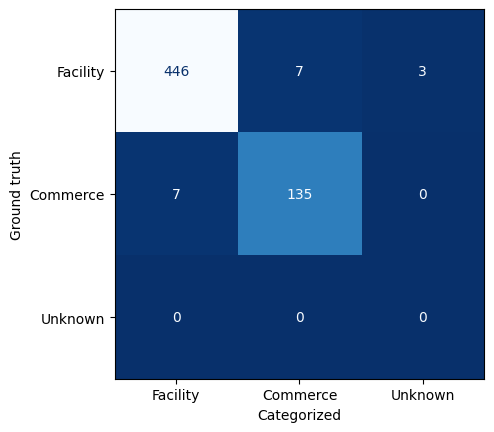

In [87]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
labels  = ['Facility', 'Commerce', 'Unknown']
cm = confusion_matrix(val.gt_place_type, val.place_type, labels=labels)

ConfusionMatrixDisplay(cm,display_labels=labels).plot(colorbar=False,cmap='Blues_r')

plt.xlabel('Categorized')
plt.ylabel('Ground truth')
plt.savefig(f'result-visual/confusion-matrix-{VAL_COUNTRY}.pdf',bbox_inches='tight',pad_inches=0)
plt.show()

In [88]:
from sklearn.metrics import classification_report
print(classification_report(val.gt_place_type, val.place_type, labels=['Facility','Commerce']))

              precision    recall  f1-score   support

    Facility       0.98      0.98      0.98       456
    Commerce       0.95      0.95      0.95       142

   micro avg       0.98      0.97      0.97       598
   macro avg       0.97      0.96      0.97       598
weighted avg       0.98      0.97      0.97       598



# Export

In [89]:
# clean data
todrop = data.loc[data.place_type == 'Forbidden']
print(len(todrop))
data = data.drop(todrop.index)

data.pop('tags');data.pop('osm');data.pop('crd');

0


KeyError: 'tags'

In [ ]:
for item in COUNTRIES:
    item_data = data.loc[data.country == item]
    item_data.to_parquet(f'result-method/safeweb-{item}.parquet',index=False)
    item_data.to_csv(f'result-method/safeweb-{item}.csv',index=False)

frame_info(data)